In [0]:
# https://keras.io/
!pip install -q keras
import keras

Using TensorFlow backend.


In [0]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam

In [0]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf
from keras import backend as k

# Don't pre-allocate memory; allocate as-needed
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 50
l = 40
num_filter = 24
compression = 0.5
dropout_rate = 0.2

In [0]:
# Load CIFAR10 Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
#AUGMENTATION

save_dir = "/files"
res_dir = "/results"
model_name = 'convnet_cifar10'



In [0]:
!pip install dill

from __future__ import print_function
import tensorflow as tf
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam
from keras.layers.pooling import MaxPooling2D
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils import to_categorical
from keras.models import load_model

import os
import dill as pickle
import numpy as np

# set random seeds for reproducibility
tf.reset_default_graph()
tf.set_random_seed(343)
np.random.seed(343)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_test /= 255.0

# Load label names to use in prediction results
label_list_path = 'datasets/cifar-10-batches-py/batches.meta'

keras_dir = os.path.expanduser(os.path.join('~', '.keras'))
datadir_base = os.path.expanduser(keras_dir)
if not os.access(datadir_base, os.W_OK):
    datadir_base = os.path.join('/tmp', '.keras')
label_list_path = os.path.join(datadir_base, label_list_path)

with open(label_list_path, mode='rb') as f:
    labels = pickle.load(f)

ckpt_dir = os.path.join(save_dir,"checkpoints")
if not os.path.isdir(ckpt_dir):
    os.makedirs(ckpt_dir)

model_path = os.path.join(res_dir, model_name + ".kerasave")
hist_path = os.path.join(res_dir, model_name + ".kerashist")

# Function to find latest checkpoint file
def last_ckpt(dir):
  fl = os.listdir(dir)
  fl = [x for x in fl if x.endswith(".hdf5")]
  cf = ""
  if len(fl) > 0:
    accs = [float(x.split("-")[3][0:-5]) for x in fl]
    m = max(accs)
    iaccs = [i for i, j in enumerate(accs) if j == m]
    fl = [fl[x] for x in iaccs]
    epochs = [int(x.split("-")[2]) for x in fl]
    cf = fl[epochs.index(max(epochs))]
    cf = os.path.join(dir,cf)
  
  return(cf)

import matplotlib.pyplot as plt
from math import *

#Visualizing CIFAR 10, takes indicides and shows in a grid
def cifar_grid(X,Y,inds,n_col, predictions=None):
  if predictions is not None:
    if Y.shape != predictions.shape:
      print("Predictions must equal Y in length!")
      return(None)
  N = len(inds)
  n_row = int(ceil(1.0*N/n_col))
  fig, axes = plt.subplots(n_row,n_col,figsize=(10,10))
  
  clabels = labels["label_names"]
  for j in range(n_row):
    for k in range(n_col):
      i_inds = j*n_col+k
      i_data = inds[i_inds]
      
      axes[j][k].set_axis_off()
      if i_inds < N:
        axes[j][k].imshow(X[i_data,...], interpolation='nearest')
        label = clabels[np.argmax(Y[i_data,...])]
        axes[j][k].set_title(label)
        if predictions is not None:
          pred = clabels[np.argmax(predictions[i_data,...])]
          if label != pred:
            label += " n"
            axes[j][k].set_title(pred, color='red')            
  
  fig.set_tight_layout(True)
  return(fig)

print('Using real-time data augmentation.')
# This will do preprocessing and realtime data augmentation:
datagen = ImageDataGenerator(
	featurewise_center=False,  # set input mean to 0 over the dataset
	samplewise_center=False,  # set each sample mean to 0
	featurewise_std_normalization=False,  # divide inputs by std of the dataset
	samplewise_std_normalization=False,  # divide each input by its std
	zca_whitening=False,  # apply ZCA whitening
	rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
	width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
	height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
	horizontal_flip=True,  # randomly flip images
	vertical_flip=False)  # randomly flip images

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Using real-time data augmentation.


/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


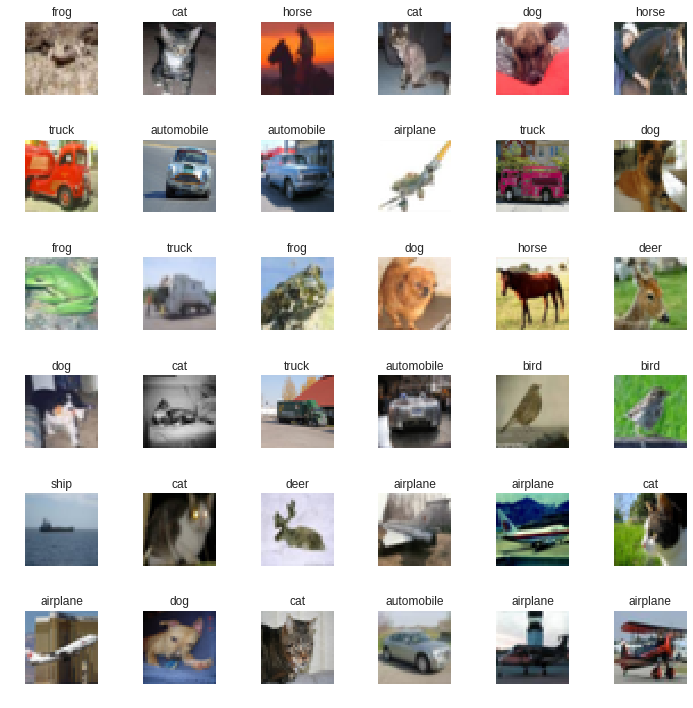

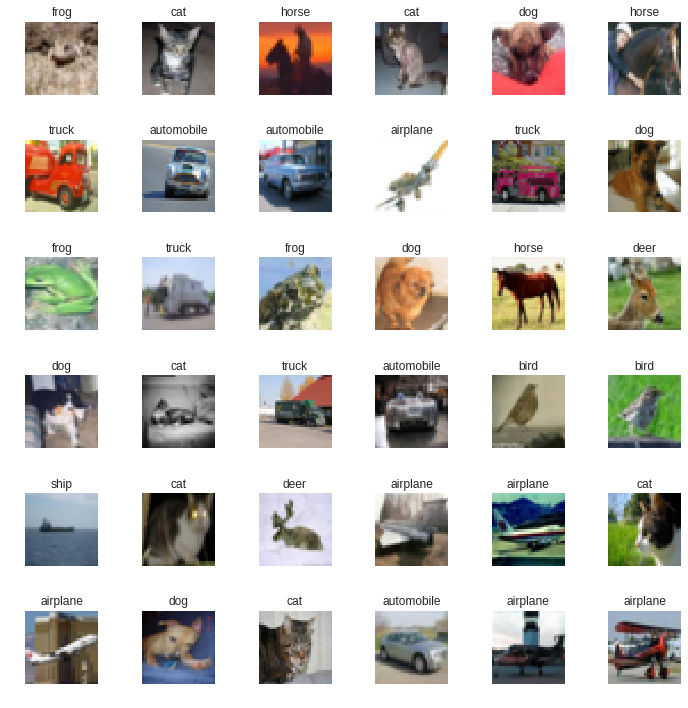

In [0]:

indices = [np.random.choice(range(len(x_train))) for i in range(36)]

cifar_grid(x_train,y_train,indices,6)

In [0]:
# Dense Block
def add_denseblock(input, num_filter = 24, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        relu = Activation('relu')(BatchNorm)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
          Conv2D_3_3 = Dropout(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

In [0]:
def add_transition(input, num_filter = 24, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [0]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    relu = Activation('relu')(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(relu)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    
    return output

In [0]:
num_filter = 24
dropout_rate = 0.2
l = 24
input = Input(shape=(img_height, img_width, channel,))
First_Conv2D = Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)


In [0]:
model = Model(inputs=[input], outputs=[output])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 24)   96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 24)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

dropout_60 (Dropout)            (None, 8, 8, 12)     0           conv2d_61[0][0]                  
__________________________________________________________________________________________________
concatenate_58 (Concatenate)    (None, 8, 8, 132)    0           concatenate_57[0][0]             
                                                                 dropout_60[0][0]                 
__________________________________________________________________________________________________
batch_normalization_61 (BatchNo (None, 8, 8, 132)    528         concatenate_58[0][0]             
__________________________________________________________________________________________________
activation_61 (Activation)      (None, 8, 8, 132)    0           batch_normalization_61[0][0]     
__________________________________________________________________________________________________
conv2d_62 (Conv2D)              (None, 8, 8, 12)     14256       activation_61[0][0]              
__________

In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [0]:
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/50


RuntimeError: ignored

In [0]:
# Test the model
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 13s 1ms/step
Test loss: 0.7949684534072876
Test accuracy: 0.7609


In [0]:
# Save the trained weights in to .h5 format
model.save_weights("DNST_model.h5")
print("Saved model to disk")

Saved model to disk


In [0]:
from google.colab import files

files.download('DNST_model.h5')